In [ ]:
# Create a convolutional neural network from zero without using any deep learning library

In [6]:
# Load mnist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.datasets import mnist

# Split train into train and validation
(X_train, y_train), (X_val, y_val) = keras.datasets.mnist.load_data()

# Normalize
X_train = X_train / 255
X_val = X_val / 255

# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

# One hot encoding
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [75]:
# Write a simple function that achieves the convolution operation efficiently for two- dimensional and three-dimensional inputs. This should allow you to input a set of convolutional filters (‘kernels’ in Keras’s terminology) and an input layer (or image) as inputs. The input layer should have a third dimension, representing a stack of feature maps, and each filter should have a third dimension of corresponding size. The function should output a number of two-dimensional feature maps corresponding to the number of input filters, though these can be stacked into a third dimensional like the input layer.

# Convolution function
def convolve2d(image, kernel):
    # Check if the image is grayscale or not
    if image.shape[2] == 1:
        # Check that all kernels are grayscale
        for i in range(len(kernel)):
            if len(kernel[i].shape) == 3:
                raise Exception('Image is GS and kernels are not')
    if image.shape[2] == 3:
        # Check that all kernels are RGB
        for i in range(len(kernel)):
            if len(kernel[i].shape) == 2:
                raise Exception('Image is RGB and kernels are not')

# Apply the filters to the image
    post_filters = []
    for i in range(len(kernel)):
        post_filter = np.zeros((image.shape[0] - kernel[i].shape[0] + 1, image.shape[1] - kernel[i].shape[1] + 1))
        for j in range(post_filter.shape[0]):
            for k in range(post_filter.shape[1]):
                post_filter[j, k] = np.sum(image[j:j + kernel[i].shape[0], k:k + kernel[i].shape[1]] * kernel[i]) # <- Matrix multiplication
        print ("post_filter shape: ") 
        print(post_filter.shape)
        post_filters.append(post_filter)
        
    #return post_filters
   
# Get one vertical feature map and one horizontal feature map for every filter
    feature_maps = []
    for i in range(len(post_filters)):
        vertical = post_filters[i][::2, 1::2]
        horizontal = post_filters[i][1::2, ::2]
        feature_maps.append(np.dstack((vertical, horizontal)))
    return feature_maps



In [29]:
x = convolve2d(X_train[0], [np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]), np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])])

post_filter shape: 
(26, 26)
post_filter shape: 
(26, 26)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.11022302e-16  0.00000000e+00 -1.11022302e-16  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.11022302e-16
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  5.55111512e-17  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.000

post_filter shape: 
(26, 26)
post_filter shape: 
(26, 26)
post_filter shape: 
(26, 26)
post_filter shape: 
(26, 26)


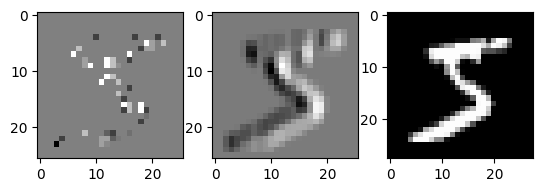

In [65]:
# Plot the vertical and horizontal feature maps for the first filter
x_train_0_post = convolve2d(X_train[0], [np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]), np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])])

plt.subplot(1, 3, 1)
plt.imshow(x_train_0_post[0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(x_train_0_post[1], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(X_train[0], cmap='gray')


post_filter shape: 
(1199, 1200)
post_filter shape: 
(1199, 1200)
post_filter shape: 
(1199, 1200)


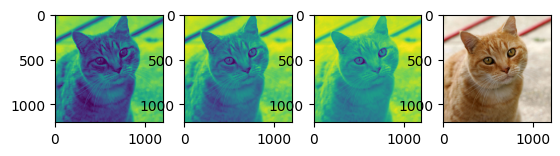

In [68]:
# load cat picture
from PIL import Image

img = Image.open('cat.jpeg')
cat = np.array(img) / 255

# rgb 3d filters
filter_r = np.array([[[0,0,1]]])
filter_g = np.array([[[0,1,0]]])
filter_b = np.array([[[1,0,0]]])

cat_post = convolve2d(cat, [filter_r, filter_g, filter_b])
# Plot the vertical and horizontal feature maps for the first filter
plt.subplot(1, 4, 1)
plt.imshow(cat_post[0])
plt.subplot(1, 4, 2)
plt.imshow(cat_post[1])
plt.subplot(1, 4, 3)
plt.imshow(cat_post[2])
plt.subplot(1, 4, 4)
plt.imshow(cat)

post_filter shape: 
(1197, 1198)
post_filter shape: 
(1197, 1198)
post_filter shape: 
(1197, 1198)


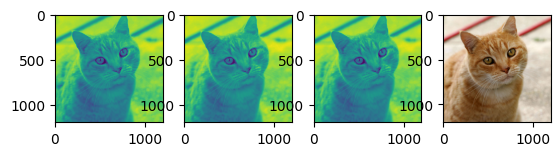

In [70]:
# 3x3x3 filters
filter_1 = np.array([[[1, 0, -1], [1, 0, -1], [1, 0, -1]], [[1, 1, 1], [0, 0, 0], [-1, -1, -1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1]]])
filter_2 = np.array([[[1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 0, -1], [1, 0, -1], [1, 0, -1]], [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]])
filter_3 = np.array([[[1, 1, 1], [0, 0, 0], [-1, -1, -1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 0, -1], [1, 0, -1], [1, 0, -1]]])

cat_post_3x3x3 = convolve2d(cat, [filter_1, filter_2, filter_3])

plt.subplot(1, 4, 1)
plt.imshow(cat_post_3x3x3[0])
plt.subplot(1, 4, 2)
plt.imshow(cat_post_3x3x3[1])
plt.subplot(1, 4, 3)
plt.imshow(cat_post_3x3x3[2])
plt.subplot(1, 4, 4)
plt.imshow(cat)


In [74]:
cat_post[0].shape

(1199, 1200)

In [73]:
cat_post_3x3x3[0].shape


(1197, 1198)

In [76]:
cat_post_vertical, cat_post_horizontal = convolve2d(cat, [filter_1, filter_2, filter_3])[0]

post_filter shape: 
(1197, 1198)
post_filter shape: 
(1197, 1198)
post_filter shape: 
(1197, 1198)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 599 and the array at index 1 has size 598

In [77]:
img_2 = Image.open('img_sq.jpeg')
sq = np.array(img_2) / 255

# rgb 3d filters

sq_post_vert, sq_post_hor = convolve2d(sq, [filter_r, filter_g, filter_b])[0]

post_filter shape: 
(225, 225)
post_filter shape: 
(225, 225)
post_filter shape: 
(225, 225)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 113 and the array at index 1 has size 112

In [78]:
sq.shape

(225, 225, 3)